# Deep Learning

## HW4- Problem 1 - Seq to Seq model for poem generating


1.   Full Name: Mohammad Kalbasi
2.   Student Number: 401211028

In [ ]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import pickle 


import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention,GRU,Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.layers

from tensorflow.keras.models import Model, load_model

from tqdm.notebook import tqdm
from itertools import chain


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # we use google drive to load files and save models there! so change path files based on your own data and run the code!

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/MyDrive/deep_learning/HW04/ferdousi.txt') as f:
  lines = [line.rstrip('\n') for line in f]
  ferdousi = [line for line in lines if line]
ferdousi = ferdousi[2:]


plotting distribution of words so we can have a sense how many times each word repear

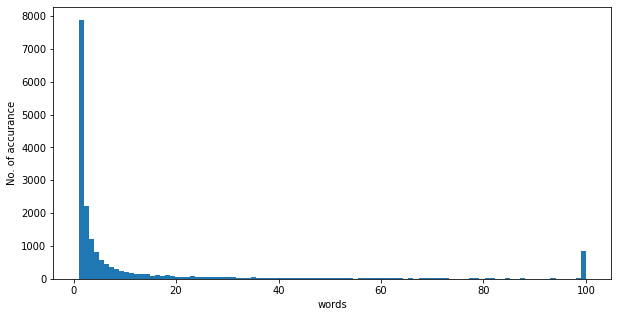

In [ ]:
all_words = []
for i in range(len(ferdousi)):
  all_words.append(ferdousi[i].split())
all_words = list(chain.from_iterable(all_words))
values, counts = np.unique(all_words, return_counts=True)
sorted = np.argsort(counts)
values_sort = values[sorted]
counts_sort = counts[sorted]
import matplotlib.pyplot as plt
 
  
  
fig = plt.figure(figsize = (10, 5))
counts[counts>100] = 100
# creating the bar plot
plt.hist(counts,bins = 100)
 
plt.xlabel("words")
plt.ylabel("No. of accurance")
plt.show()

 

In [ ]:
bait_ferdosi = []
for i in range(0,len(ferdousi)-1,2):
  temp_b8 = ferdousi[i] + " <bos> " + ferdousi[i+1]
  bait_ferdosi.append(temp_b8)


In [ ]:
bait_ferdosi[0]

'به نام خداوند جان و خرد <bos> کزین برتر اندیشه برنگذرد'

## important note:
 we add "bos" token (between of sentence) to make our model undrestand different parts of poem, so we hope that it force that our model to have rhythm , but as you can see first part of poem is on left and then second part is on right of "bos" token, for example when reading this first you should read:

 به نام خداوند جان و خرد

 and then 

 کزین برتر اندیشه برنگذرد

In [ ]:
for i in range(len(bait_ferdosi)):
  bait_ferdosi[i] =  '<sos> ' + "".join(bait_ferdosi[i]) + ' <eos>'

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>',num_words=10000)
tokenizer.fit_on_texts(bait_ferdosi)

In [ ]:
# printing vocab size
vocab_size = len(tokenizer.word_index)+1
print(f"number of unique word in our created vocabulary = {vocab_size}")
print(tokenizer.word_index)

number of unique word in our created vocabulary = 18011
{'<oov>': 1, 'sos': 2, 'bos': 3, 'eos': 4, 'و': 5, 'به': 6, 'که': 7, 'ز': 8, 'از': 9, 'بر': 10, 'را': 11, 'چو': 12, 'با': 13, 'همی': 14, 'گفت': 15, 'شد': 16, 'شاه': 17, 'تو': 18, 'بود': 19, 'او': 20, 'یکی': 21, 'همه': 22, 'آن': 23, 'اندر': 24, 'من': 25, 'در': 26, 'تا': 27, 'سر': 28, 'دل': 29, 'چنین': 30, 'کرد': 31, 'آمد': 32, 'پیش': 33, 'این': 34, 'جهان': 35, 'بد': 36, 'پر': 37, 'بدو': 38, 'هر': 39, 'سپاه': 40, 'چون': 41, 'داد': 42, 'پس': 43, 'دو': 44, 'نه': 45, 'راه': 46, 'ای': 47, 'روی': 48, 'سوی': 49, 'کار': 50, 'لشکر': 51, 'سخن': 52, 'چه': 53, 'تخت': 54, 'بی': 55, 'هم': 56, 'ما': 57, 'مرد': 58, 'جنگ': 59, 'مرا': 60, 'گر': 61, 'جای': 62, 'دست': 63, 'زمین': 64, 'گرد': 65, 'ایران': 66, 'گشت': 67, 'بیامد': 68, 'همان': 69, 'روز': 70, 'یک': 71, 'باد': 72, 'بدین': 73, 'کسی': 74, 'شهریار': 75, 'رای': 76, 'بدان': 77, 'خویش': 78, 'کس': 79, 'ازان': 80, 'تن': 81, 'تاج': 82, 'اگر': 83, 'نام': 84, 'گنج': 85, 'اوی': 86, 'بران': 87, 'آفرین': 

In [ ]:
tokenized_poet = []
MAXLEN = -1
for i in range(len(bait_ferdosi)):
  tokenized = tokenizer.texts_to_sequences(bait_ferdosi[i].split())
  tokenized = list(chain.from_iterable(tokenized))
  tokenized = np.asarray(tokenized)
  if (len(tokenized) > MAXLEN):
    MAXLEN = len(tokenized)
  tokenized_poet.append(tokenized)
print(f"Max length of each line = {MAXLEN}")
print(f"first sample = {tokenized_poet[0]}")

Max length of each line = 23
first sample = [   2    6   84  366  120    5  102    3  368  700  287 3574    4]


In [ ]:
encoder_input = []
decoder_input = []
decoder_output = []
padded_all = pad_sequences(list(tokenized_poet), maxlen=MAXLEN, padding="post")
for i in range(0,len(tokenized_poet)-1,1):
  encoder_input.append(padded_all[i])
  temp_decod = padded_all[i+1]
  decoder_input.append(temp_decod[0:-1])
  decoder_output.append(temp_decod[1:])

In [ ]:
print(f"first input of encoder = {encoder_input[0]}")
print(f"first input of decoder = {decoder_input[0]}")
print(f"first output of decoder = {decoder_output[0]}")


first input of encoder = [   2    6   84  366  120    5  102    3  368  700  287 3574    4    0
    0    0    0    0    0    0    0    0    0]
first input of decoder = [  2 366  84   5 366  62   3 366 666 262 430   4   0   0   0   0   0   0
   0   0   0   0]
first output of decoder = [366  84   5 366  62   3 366 666 262 430   4   0   0   0   0   0   0   0
   0   0   0   0]


we train model in teacher forcing mode, so output decoder is just one index shifted of decoder input.

In [ ]:
latent_dim = 512
num_decoder_tokens = len(tokenizer.word_index)+1
embedding = Embedding(
    input_dim=len(tokenizer.word_index)+1,
    output_dim=100,
    
)

encoder_inputs = Input(shape=(MAXLEN,))
x = embedding(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
x2 =embedding(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(x2,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])
encoder_input_array = np.asarray(encoder_input[0:49600])
decoder_input_array = np.asarray(decoder_input[0:49600])
decoder_output_array = np.asarray(decoder_output[0:49600])

In [ ]:
history = model.fit([encoder_input_array, decoder_input_array], decoder_output_array,
          batch_size=64,
          epochs=40,
          validation_split=0.2,
          )

Epoch 1/40
620/620 [==============================] - 59s 89ms/step - loss: 3.7581 - accuracy: 0.4816 - val_loss: 3.3634 - val_accuracy: 0.5197
Epoch 2/40
620/620 [==============================] - 40s 65ms/step - loss: 3.1958 - accuracy: 0.5207 - val_loss: 3.1741 - val_accuracy: 0.5326
Epoch 3/40
620/620 [==============================] - 40s 65ms/step - loss: 2.9782 - accuracy: 0.5353 - val_loss: 3.0395 - val_accuracy: 0.5428
Epoch 4/40
620/620 [==============================] - 40s 64ms/step - loss: 2.7940 - accuracy: 0.5489 - val_loss: 2.9307 - val_accuracy: 0.5531
Epoch 5/40
620/620 [==============================] - 40s 65ms/step - loss: 2.6390 - accuracy: 0.5609 - val_loss: 2.8581 - val_accuracy: 0.5612
Epoch 6/40
620/620 [==============================] - 40s 65ms/step - loss: 2.5128 - accuracy: 0.5711 - val_loss: 2.8145 - val_accuracy: 0.5662
Epoch 7/40
620/620 [==============================] - 40s 64ms/step - loss: 2.4095 - accuracy: 0.5797 - val_loss: 2.7884 - val_accuracy:

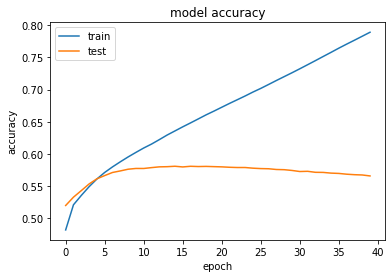

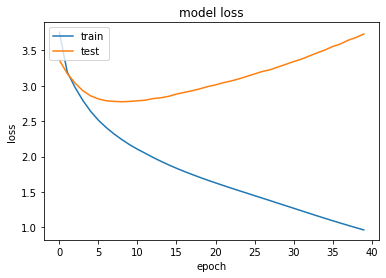

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

we got reasonable accuracy but as we showed before, distribution of words is very focused on certain words so if model learns to output them, we should get good accuracy but bad result, so we have to print our outputs to make sure that model works as we intended to.

creating revrese token dictionaries so we can turn outputs to word

In [ ]:
reverse_target_char_index = tokenizer.index_word
target_token_index = tokenizer.word_index

creting seperate decoder and encoder models (based on what we previously trained)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    embedding(decoder_inputs), initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

a deterministic funtion for generating poem, in this method we get single beyt of ferdosi poet and always gives same output

In [ ]:
def text_from_token(input_vec):
  txt = ""
  for i in range(len(input_vec)):
    if ((input_vec[i]) != 0):
      txt += " " + reverse_target_char_index[(input_vec[i])]
  return txt
    

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,))
  # Populate the first character of target sequence with the start character.
  target_seq[0,] = 1
  target_seq = np.reshape(target_seq,(1,len(target_seq)))

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
      output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value, verbose=0)

      # Sample a token
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += " " +sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoded_sentence) > 3*MAXLEN):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,))
      target_seq[0,] = sampled_token_index
      target_seq = np.reshape(target_seq,(1,len(target_seq)))


      # Update states
      states_value = [h, c]



  return decoded_sentence

printing a sample input with our function

In [ ]:
text_from_token(encoder_input[494])

' sos چنان بدگهر شوخ فرزند او bos بگشت از ره داد و پیوند او eos'

**as we estated befor, you should read left part of bos first and then right part**
and we added bos token just to show between of different part of poem (first and second mesrah) and this way, making model to learn poem pattern 

now using encoder decoder to create a new poem, first we use train data for encoding part and creating input for our decoder

In [ ]:
input_seq = np.reshape(encoder_input[490],(1,MAXLEN))
decode_sequence(input_seq)

1/1 [==============================] - 0s 16ms/step


' یکی تیغ زد بر سر و ترگ اوی bos که ای آرزومند چندین بگوی eos'

as we can see, it is pretty good( it got rhythm  and rhyme, and some familiar pattern but it is also a brand new poet ( you cant find it in input) so network really learned patterns (instead of just memorising train data, in other word overfitting) so model can generate new poems and it is not overfited

In [ ]:
text_from_token(decoder_input[490])

' sos به چاه اندر افتاد و بشکست پست bos شد آن نیکدل مرد یزدان پرست eos'

so as you can see, model created entirely different output for input 490, so model indeed is not overfitted but it learned input patters and repeat them so output is have somewhat pattern, but it doesn't have meaning. 

testing it for a input that we didn't train model on

In [ ]:
input_seq = np.reshape(encoder_input[49606],(1,MAXLEN))
decode_sequence(input_seq)

1/1 [==============================] - 0s 17ms/step


' چنین است رای خردمند شاه bos کزان کار دیده مدارید راه eos'

as we can see it works great! it has rythem and its somewhat makes sense and it also has ferdosi style of writing poems, so network does really works

we can also give poems of other poets and see the result

In [ ]:
a = "نیازار موری که دانه کش است"
b = "که جان دارد و جان شیرین خوش است"
beit_fake = a + " <bos> " + b
beit_fake = "<sos> " + beit_fake + " <eos>"
tokenized = tokenizer.texts_to_sequences(beit_fake.split())
tokenized = list(chain.from_iterable(tokenized))


In [ ]:
tokenized_arr = np.asarray(tokenized)
tokenized = np.zeros((23))
tokenized[0:len(tokenized_arr)] = tokenized_arr[0:len(tokenized_arr)]
input_seq = np.reshape(tokenized,(1,MAXLEN))
decode_sequence(input_seq)

1/1 [==============================] - 0s 333ms/step


' چو از کوه سر برکشد سرو ماه bos به سر بر همی موج دریای چین eos'

we can see that if input isn't from ferdosis work, output isn't as good as when it is, in other words encoder really works and learned to encoder

for making model generative, in processing output, after using softmax layer we choose output based on the created distribution (instead of just using argmax) this makes to have multiple outputs for same input so with this method, we have a generative model

In [ ]:
def decode_sequence_random(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,))
  # Populate the first character of target sequence with the start character.
  target_seq[0,] = 1
  target_seq = np.reshape(target_seq,(1,len(target_seq)))

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
      output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value, verbose=0)

      # Sample a token
      prob_list = output_tokens[0, -1, :]
      sampled_token_index = np.random.choice(np.arange(0, len(prob_list)), p=prob_list) # this part make model generative!

     # sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += " " +sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoded_sentence) > 3*MAXLEN):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,))
      target_seq[0,] = sampled_token_index
      target_seq = np.reshape(target_seq,(1,len(target_seq)))


      # Update states
      states_value = [h, c]



  return decoded_sentence

giving same input and seeing if we get different outputs or not

In [ ]:
input_seq = np.reshape(encoder_input[49606],(1,MAXLEN))
decode_sequence_random(input_seq)

1/1 [==============================] - 0s 17ms/step


' بی آزار تو جست بی خواب نیست bos جز آهنگ پیکار او بند نیست eos'

In [ ]:
input_seq = np.reshape(encoder_input[49606],(1,MAXLEN))
decode_sequence_random(input_seq)

1/1 [==============================] - 0s 15ms/step


' اگر شاه بیند و تندی مکن bos به تندی که باشد کسی در کمین eos'

so we can see in this method, we have drastically different outputs when we use same input, in this method outpus are not always as good as always choosing most probable output of lstm, like it has  rhythm  and rhyme but sometimes output could also be very bad, other method is to only for first word afer start and then after always choose most probable output so this way we have different outputs but we expect to have better outputs overall

In [ ]:
def decode_sequence_random_first(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,))
  # Populate the first character of target sequence with the start character.
  target_seq[0,] = 1
  target_seq = np.reshape(target_seq,(1,len(target_seq)))

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  flag = 0
  while not stop_condition:
      output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value, verbose=0)

      # Sample a token
      if flag == 0:
        prob_list = output_tokens[0, -1, :]
        sampled_token_index = np.random.choice(np.arange(0, len(prob_list)), p=prob_list) # this part make model generative!
        flag = 1
      else:
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

     # sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += " " +sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoded_sentence) > 3*MAXLEN):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,))
      target_seq[0,] = sampled_token_index
      target_seq = np.reshape(target_seq,(1,len(target_seq)))


      # Update states
      states_value = [h, c]



  return decoded_sentence

In [ ]:
input_seq = np.reshape(encoder_input[49606],(1,MAXLEN))
decode_sequence_random_first(input_seq)

1/1 [==============================] - 0s 19ms/step


' اگر شاه بیند ز بن چون اوی bos دلت کرد باید بدین روی اوی eos'

In [ ]:
input_seq = np.reshape(encoder_input[49606],(1,MAXLEN))
decode_sequence_random_first(input_seq)

1/1 [==============================] - 0s 21ms/step


' چه گویید و این را چه پاسخ دهید bos همه پند و روزی بباید دهید eos'

now it is what we wanted! it has good rhythm , and it does have rhyme and somewhat meaning, we can clearly see it has style of ferdosi but generated poem are new ( we can see it has copied some word patterns in ferdosis poem, but overall if you search it you can't find created poem in any of ferdosies work) but to be honest, they don't always totally make sense, it learned the style of poet but the model couldn't always give us output that has a good meaning ( it make sense partially, but if we look at overall created poem, it may not make sense)
lets try giving model some other inputs and see its effect

In [ ]:
input_seq = np.reshape(encoder_input[117],(1,MAXLEN))

for i in range(4):
  print(f"{i} created poet from same input")
  print(decode_sequence_random_first(input_seq))
  print('\n')

0 created poet from same input
1/1 [==============================] - 0s 16ms/step
 گر از ما همی باژ خواهی رواست bos که جانت برنج از جهان نشمرد eos


1 created poet from same input
1/1 [==============================] - 0s 18ms/step
 چو از کشورم بگذری در جهان bos نکوهش بیاید بدین برگزین eos


2 created poet from same input
1/1 [==============================] - 0s 18ms/step
 برین نیکویها به کام تواند bos کزین چهر خود نام کردش به کار eos


3 created poet from same input
1/1 [==============================] - 0s 14ms/step
 چو از کشورم بگذری در جهان bos نکوهش بیاید بدین برگزین eos




they are good! because we only choose first word(after start) randomly we can see there is probability that we have repeated output(in this case output 1 and 3 are same) but they are all good outputs!

In [ ]:
input_seq = np.reshape(encoder_input[666],(1,MAXLEN))

for i in range(4):
  print(f"{i} created poet from same input")
  print(decode_sequence_random_first(input_seq))
  print('\n')

0 created poet from same input
1/1 [==============================] - 0s 49ms/step
 پدر بر میان سپاه اندرون bos که گفتی بسوزد زمین را ز خون eos


1 created poet from same input
1/1 [==============================] - 0s 14ms/step
 زمین بر زمین بر <oov> bos جهان پر ز ابر <oov> گرد eos


2 created poet from same input
1/1 [==============================] - 0s 15ms/step
 چنان زخم او بر زمین آن بدید bos به کردار آتش کمان بردمید eos


3 created poet from same input
1/1 [==============================] - 0s 14ms/step
 چنان زخم او بر زمین آن بدید bos به کردار آتش کمان بردمید eos




so with different inputs, we get different outputs and also with same input we usually get different outputs(there is probability to have same output because in our proposed generative model we only choose first word randomly ( we showed that if we sample all outputs randomly based of created distribution by model, it isn't always as good as chosing argmax of output of model and because of that we only choose first word randomly (based of distribution created by lstm output) and then only choosing most probable output(argmax), it is possible to make outputs more random by choosing more words randomly(once again, when we say randomly we mean random using distribution created by netwrok outputs, so yes every word have a probability to be seen but based of input of network, distribution will have a great bias toward 3 or 4 words so they usually will be chosen and after that we will have same pattern) instead of just first word, we can use first two or three words, lets try first two word

In [ ]:
def decode_sequence_random_first_three(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,))
  # Populate the first character of target sequence with the start character.
  target_seq[0,] = 1
  target_seq = np.reshape(target_seq,(1,len(target_seq)))

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  flag = 0
  while not stop_condition:
      output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value, verbose=0)

      # Sample a token
      if flag != 3:
        prob_list = output_tokens[0, -1, :]
        sampled_token_index = np.random.choice(np.arange(0, len(prob_list)), p=prob_list) # this part make model generative!
        flag = flag + 1
      else:
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

     # sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += " " +sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoded_sentence) > 3*MAXLEN):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,))
      target_seq[0,] = sampled_token_index
      target_seq = np.reshape(target_seq,(1,len(target_seq)))


      # Update states
      states_value = [h, c]



  return decoded_sentence

In [ ]:
input_seq = np.reshape(encoder_input[666],(1,MAXLEN))

for i in range(4):
  print(f"{i} created poet from same input")
  print(decode_sequence_random_first_three(input_seq))
  print('\n')

0 created poet from same input
1/1 [==============================] - 0s 16ms/step
 پس از میمنه گیو گرد سپاه bos بیامد بر رستم کینه خواه eos


1 created poet from same input
1/1 [==============================] - 0s 14ms/step
 زمین بر چه خاک و دو پایش به خاک bos همه گبر و برگستوان چاک چاک eos


2 created poet from same input
1/1 [==============================] - 0s 15ms/step
 بکردار کوه تو بر کوه و کوه bos به نوک نگین و درفش و گروه eos


3 created poet from same input
1/1 [==============================] - 0s 18ms/step
 زمین سم ایدر چو دریا به پای bos همی رفت از کوه تا جای دست eos




In [ ]:
input_seq = np.reshape(encoder_input[4096],(1,MAXLEN))

for i in range(4):
  print(f"{i} created poet from same input")
  print(decode_sequence_random_first_three(input_seq))
  print('\n')

0 created poet from same input
1/1 [==============================] - 0s 17ms/step
 پس از کار یزدان چو شیر ژیان bos که گردد کهن گشته و ماه و نه eos


1 created poet from same input
1/1 [==============================] - 0s 15ms/step
 ازین پس مرا نیز چندی نبید bos که با تاج شاهی بباید کشید eos


2 created poet from same input
1/1 [==============================] - 0s 14ms/step
 پس از من که هر بد که من شاه نیست bos روانم بدان بخت با تو بود eos


3 created poet from same input
1/1 [==============================] - 0s 20ms/step
 یکی کم کنی دانش و رای نیست bos ز تو خوبی و دل پر و تیمار نیست eos




so we can see if we choose first three words based of output distribution, we don't see the repeated output that often, so in this case our model seems to be really generative, because for same input we get different outputs and they are also all good outputs( have rhytme and rhyme and somewhat meaning and it certainly has ferdosis style)

### **now using bidirectional GRU for our model**

there are so many options and different models for this part, when we use bidirectional gru, we have two states, so we can encode poem forward and backward, and use this two states too feed it to decoder model.
to be honest it isn't really good to have decoder bidirectional, because we create poem in forward direction but we test this two methods, first we use simple gru for decoder, so it's input is concatinacated states of encoder (for forward and backward path) 
in second method we use bidirectional decoder, so we feed two states manually

now lets try bidirectional GRU for both encoder and decoder

In [ ]:
latent_dim = 100
num_decoder_tokens = len(tokenizer.word_index)+1
embedding = Embedding(
    input_dim=len(tokenizer.word_index)+1,
    output_dim=100,
    
)

encoder_inputs = Input(shape=(MAXLEN,))
x = embedding(encoder_inputs)
encoder = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))

encoder_outputs, state_f, state_b = encoder(x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_f, state_b]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
x2 =embedding(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_gru_bi = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))

decoder_outputs, _, _ = decoder_gru_bi(x2,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model_bi = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model_bi.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])
encoder_input_array = np.asarray(encoder_input[0:49600])
decoder_input_array = np.asarray(decoder_input[0:49600])
decoder_output_array = np.asarray(decoder_output[0:49600])

when we used bidirectional model, we saw that it overfit very fast so we train just 5 epoches

In [ ]:
history = model_bi.fit([encoder_input_array, decoder_input_array], decoder_output_array,
          batch_size=64,
          epochs=5,
          validation_split=0.2)

Epoch 1/5
620/620 [==============================] - 36s 49ms/step - loss: 3.8604 - accuracy: 0.4771 - val_loss: 2.9888 - val_accuracy: 0.5506
Epoch 2/5
620/620 [==============================] - 30s 49ms/step - loss: 2.4546 - accuracy: 0.6020 - val_loss: 1.9754 - val_accuracy: 0.6937
Epoch 3/5
620/620 [==============================] - 30s 49ms/step - loss: 1.4862 - accuracy: 0.7558 - val_loss: 1.2631 - val_accuracy: 0.8178
Epoch 4/5
620/620 [==============================] - 30s 48ms/step - loss: 0.8577 - accuracy: 0.8689 - val_loss: 0.8427 - val_accuracy: 0.8889
Epoch 5/5
620/620 [==============================] - 30s 49ms/step - loss: 0.5068 - accuracy: 0.9264 - val_loss: 0.6272 - val_accuracy: 0.9219


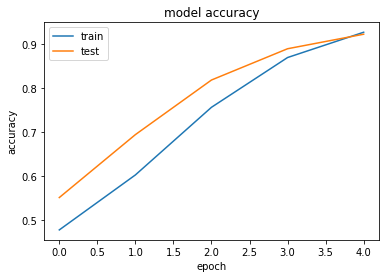

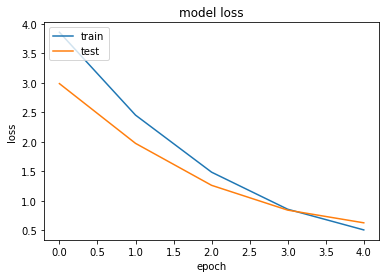

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_f = Input(shape=(latent_dim,))
decoder_state_input_b = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_f, decoder_state_input_b]
decoder_outputs, state_fg, state_bg = decoder_gru_bi(
    embedding(decoder_inputs), initial_state=decoder_states_inputs)
decoder_states = [state_fg, state_bg]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence_gru_bidirectional(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,))
  # Populate the first character of target sequence with the start character.
  target_seq[0,] = 1
  target_seq = np.reshape(target_seq,(1,len(target_seq)))

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
      output_tokens = model_bi([input_seq, target_seq])

      # Sample a token
      #prob_list = output_tokens[0, -1, :]
      #sampled_token_index = np.random.choice(np.arange(0, len(prob_list)), p=prob_list) # this part make model generative!
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      #print(sampled_token_index)
      if  sampled_token_index == 0:
        sampled_token_index = 1

      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += " " +sampled_char
      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoded_sentence) > 3*MAXLEN):
          stop_condition = True

      # Update the target sequence (of length 1).
  #    target_seq = np.zeros((1,))
   #   target_seq[0,] = sampled_token_index
      target_seq = np.hstack((target_seq,np.reshape(sampled_token_index,(1,1))))
      n1,n2 = np.shape(target_seq)
      target_seq = np.reshape(target_seq,(1,(n2)))



  return decoded_sentence

In [ ]:
input_seq = np.reshape(encoder_input[118],(1,MAXLEN))
decode_sequence_gru_bidirectional(input_seq)

1/1 [==============================] - 0s 17ms/step


' دمان خواندند آفرین خواندند آفرین خواندند آفرین خواندند <oov> <oov> <oov>'

In [ ]:
input_seq = np.reshape(encoder_input[77],(1,MAXLEN))
decode_sequence_gru_bidirectional(input_seq)

1/1 [==============================] - 0s 17ms/step


' دمان خواندند آفرین خواندند bos نگه آفرین خواندند آفرین خواندند <oov> <oov>'

as we can see, in this method output on this method are not very good and it didn't learn patter but overfitted on same things and so can't create true answers for us. partially it is because it doesnt have a good meaning to use bidirectional when decoding (because when training it seems it have full text but it has not!) and this method don't work

so lets change our approch, now we use bidirectional encdore and concatinate states for our decoder and see results

In [ ]:
latent_dim = 256
num_decoder_tokens = len(tokenizer.word_index)+1
embedding = Embedding(
    input_dim=len(tokenizer.word_index)+1,
    output_dim=100,
    
)

encoder_inputs = Input(shape=(MAXLEN,))
x = embedding(encoder_inputs)
encoder = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))

encoder_outputs, state_f, state_b = encoder(x)
# We discard `encoder_outputs` and only keep the states.
state_g = Concatenate()([state_f, state_b])

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
x2 =embedding(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, = decoder_gru(x2,initial_state=state_g)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])
encoder_input_array = np.asarray(encoder_input[0:49600])
decoder_input_array = np.asarray(decoder_input[0:49600])
decoder_output_array = np.asarray(decoder_output[0:49600])

again, because of high rate of convergence(and possibility of overfitting) we only train for 15 epochs

In [ ]:
history = model.fit([encoder_input_array, decoder_input_array], decoder_output_array,
          batch_size=64,
          epochs=15,
          validation_split=0.2)

Epoch 1/15
620/620 [==============================] - 44s 65ms/step - loss: 3.8612 - accuracy: 0.4775 - val_loss: 3.3707 - val_accuracy: 0.5205
Epoch 2/15
620/620 [==============================] - 38s 62ms/step - loss: 3.1800 - accuracy: 0.5221 - val_loss: 3.1430 - val_accuracy: 0.5341
Epoch 3/15
620/620 [==============================] - 38s 62ms/step - loss: 2.9063 - accuracy: 0.5414 - val_loss: 2.9704 - val_accuracy: 0.5485
Epoch 4/15
620/620 [==============================] - 39s 63ms/step - loss: 2.6641 - accuracy: 0.5589 - val_loss: 2.8420 - val_accuracy: 0.5609
Epoch 5/15
620/620 [==============================] - 39s 63ms/step - loss: 2.4433 - accuracy: 0.5761 - val_loss: 2.7710 - val_accuracy: 0.5698
Epoch 6/15
620/620 [==============================] - 39s 63ms/step - loss: 2.2497 - accuracy: 0.5929 - val_loss: 2.7495 - val_accuracy: 0.5740
Epoch 7/15
620/620 [==============================] - 39s 63ms/step - loss: 2.0784 - accuracy: 0.6109 - val_loss: 2.7528 - val_accuracy:

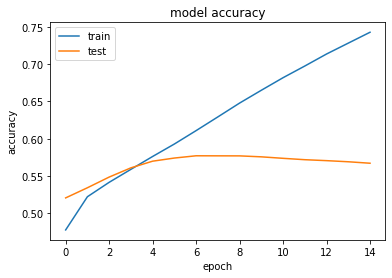

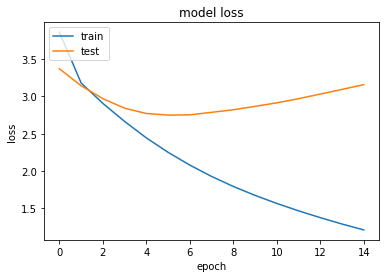

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
encoder_model = Model(encoder_inputs, state_g)

decoder_state_input_g = Input(shape=(2*latent_dim,))
decoder_outputs, state_gru = decoder_gru(
    embedding(decoder_inputs), initial_state=decoder_state_input_g)
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs, decoder_state_input_g],
    [decoder_outputs, state_gru])

In [ ]:
def decode_sequence_gru(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,))
  # Populate the first character of target sequence with the start character.
  target_seq[0,] = 1
  target_seq = np.reshape(target_seq,(1,len(target_seq)))

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
      output_tokens, states_gru = decoder_model.predict(
          [target_seq, states_value], verbose=0)

      # Sample a token
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += " " +sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoded_sentence) > 3*MAXLEN):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,))
      target_seq[0,] = sampled_token_index
      target_seq = np.reshape(target_seq,(1,len(target_seq)))


      # Update states
      states_value = states_gru



  return decoded_sentence

In [ ]:
reverse_target_char_index = tokenizer.index_word
target_token_index = tokenizer.word_index

now testing gru model when onlu choosing best outputs

In [ ]:
input_seq = np.reshape(encoder_input[7],(1,MAXLEN))
decode_sequence_gru(input_seq)

1/1 [==============================] - 0s 16ms/step


' اگر پارسا یابد از بخردان bos ز بهر تو بر نیست همداستان eos'

as we see, with this method we have solved our issues
it is good, it isn't in ferdosi(we will print original output7 to show that it isn't overfitted) so model isn't overfitted, it has rhythm  and ryhme but like before, it doesn't make sense. 

In [ ]:
text_from_token(decoder_output[7])

' ستودن نداند کس او را چو هست bos میان بندگی را ببایدت بست eos'

so this proves that model isn't overfitted (output in train and final results are different) now lets try for samples that wasn't in train data

In [ ]:
input_seq = np.reshape(encoder_input[49603],(1,MAXLEN))
decode_sequence_gru(input_seq)

1/1 [==============================] - 0s 17ms/step


' نخواهند جز نام او زردهشت bos که هر سه یاقوت را بر نشست eos'

it is good enough! we said it befor we see some patterns of ferdousi poem in outputs (like combination of words) but it isn't completly copy! so our model really generate new outputs(that have ferdousi style but they don't have meaning)

now lets make model generative by sampling 3 outputs instead of using argmax

In [ ]:
def decode_sequence_gru_generative(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,))
  # Populate the first character of target sequence with the start character.
  target_seq[0,] = 1
  target_seq = np.reshape(target_seq,(1,len(target_seq)))

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  flag = 0
  while not stop_condition:
      output_tokens, states_gru = decoder_model.predict(
          [target_seq, states_value], verbose=0)

      # Sample a token
      if flag != 3:
        prob_list = output_tokens[0, -1, :]
        sampled_token_index = np.random.choice(np.arange(0, len(prob_list)), p=prob_list) # this part make model generative!
        flag = flag + 1
      else:
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += " " +sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoded_sentence) > 3*MAXLEN):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,))
      target_seq[0,] = sampled_token_index
      target_seq = np.reshape(target_seq,(1,len(target_seq)))


      # Update states
      states_value = states_gru



  return decoded_sentence

In [ ]:
input_seq = np.reshape(encoder_input[4096],(1,MAXLEN))

for i in range(4):
  print(f"{i} created poem from same input")
  print(decode_sequence_gru_generative(input_seq))
  print('\n')

0 created poet from same input
1/1 [==============================] - 0s 18ms/step
 هران کس که او را سر آرد زمان bos بکژی و <oov> نبندد روان eos


1 created poet from same input
1/1 [==============================] - 0s 17ms/step
 که بخشش بداد و به فرمان تست bos به دیدار و دیدار تو بگذرد eos


2 created poet from same input
1/1 [==============================] - 0s 16ms/step
 تبه کرد پدرود و بنواختش bos به نزدیکی خویش بنشاختش eos


3 created poet from same input
1/1 [==============================] - 0s 18ms/step
 که باری مگر زندگانی دراز bos کند روز و رنجش برو بر فراز eos




as we can, we can have multiple outputs for same input, if we search for closest poem by hand(on the internet) we have somehting like:

که او را بود زندگانی دراز

and if you compare it to last created poem we have

که باری مگر زندگانی دراز

as we estated befor, model learns patters and in this example it learned:

زندگانی دراز

pattern but it used it in different context, so we have rhythm  but we lost meaning, it shows that this models don't learn meaning but just learn somepatterns instead(which is expected!)

testing for some different inputs:


In [ ]:
input_seq = np.reshape(encoder_input[666],(1,MAXLEN))

for i in range(4):
  print(f"{i} created poem from same input")
  print(decode_sequence_gru_generative(input_seq))
  print('\n')

0 created poem from same input
1/1 [==============================] - 0s 60ms/step
 نیاید پی مردم کینه جوی bos که بر کوه تا پیل چون پیل و کوس eos


1 created poem from same input
1/1 [==============================] - 0s 14ms/step
 که چندان پسر بود همتای اوی bos که کردار بد بد کنی رزم اوی eos


2 created poem from same input
1/1 [==============================] - 0s 14ms/step
 چنین گفت اگر دور با دیده شیر bos که هرگز برآید به آوای نیل eos


3 created poem from same input
1/1 [==============================] - 0s 16ms/step
 نیاید <oov> دو مرد مرد bos که بر چرخ گردان میانش به خاک eos




In [ ]:
input_seq = np.reshape(encoder_input[4099],(1,MAXLEN))

for i in range(4):
  print(f"{i} created poem from same input")
  print(decode_sequence_gru_generative(input_seq))
  print('\n')

0 created poem from same input
1/1 [==============================] - 0s 16ms/step
 پیاده دوان پیش او شد سپاه bos که جاوید باد این دل و نیک خواه eos


1 created poem from same input
1/1 [==============================] - 0s 14ms/step
 که آگاه شد شاه گیتی فروز bos که ما را بشادی بکردار گرد eos


2 created poem from same input
1/1 [==============================] - 0s 16ms/step
 سگ و زیرش و تیر و کمان bos به <oov> و به بند و آن بدگمان eos


3 created poem from same input
1/1 [==============================] - 0s 18ms/step
 نخواهد سواری چو افراسیاب bos که داند که داند که آرام و خواب eos




we can see that created poets have so many mistakes, but they have rhythm  and style of ferdousi so result are somewhat good,
it is hard to compare results to LSTM they are both somewhat good, they generate new poems that doesn't exist and have acceptable rhythm, they have "ghafie" (it is easily explainable in lstm, memory can save estate of end word before bos so before ending poem, it use a word which is compatible with that word and then end the poem) 

### conclusion:
we showed that both lstm and bidirectional gru work good for generating poems, they both somewhat undrestand pattern to make rhythme and they had same style as ferdousi, created output usually didn't have a meaning and it's because these models learn patterns and really don't undrestant meaning to create a meaningfull poem!
also we showed that our proposed model based on sampling are generative, which means that for same input they can make multiple unique outputs